 # Подготовка окружения

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
import time
from pathlib import Path

## Скачиваем датасет
Потребуется kaggle ключ для доступа к данным (токен).  
Выглядит примерно так:
aleksandrivanov.
982a6e**********************45b2.

Получить можно в своём профиле:

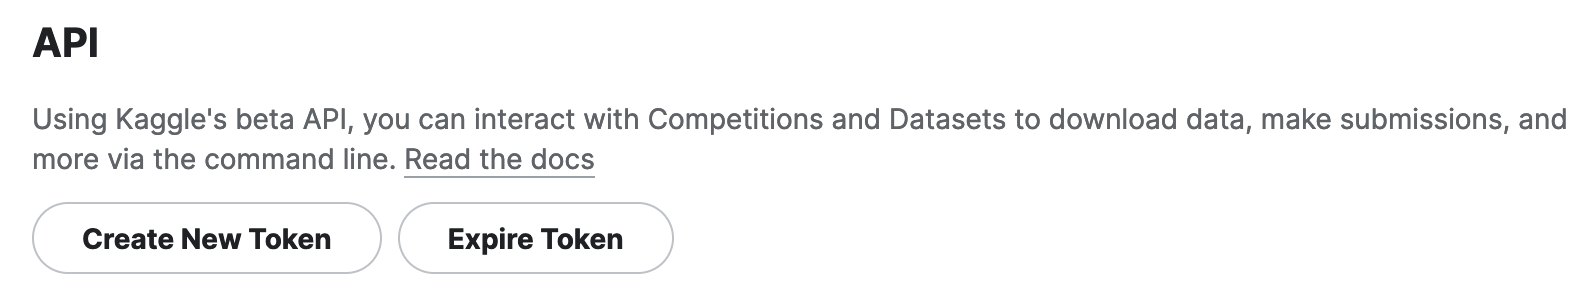

Файл подобран таким образом, чтобы был достаточно большим, чтобы не влезать в оперативную память, но достаточно мал, чтобы с ним можно было работать локально без кластера.

In [ ]:
dataset_path = Path('genius-song-lyrics-with-language-information', 'song_lyrics.csv')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information')

In [ ]:
# Количество ядер
!nproc

2


# Задача 5

## Вариант "в лоб"

Здесь показана реализация с помощью пандаса

In [ ]:
# Неправильно, упадёт из-за нехватки памяти
# df = pd.read_csv(dataset_path)

## Правильное решение

Обработка файла по частям. Как будет видно мультипроцессорная обработка не всегда самая быстрая, так как у нас появляются дополнительные накладные расходы на мультипоточную реализацию. Но такая реализация позволяет считать, что нельзя посчитать на одном компьютере, хоть и с накладными расходами.

А функции map и reduce позволяют делать код проще и масштабируемей.

###  Считывем с помощью пандас

In [ ]:
# Вариант с циклом
# Задача 4
chunksize = 100_000
df_chunks = pd.read_csv(
    dataset_path,
    chunksize=chunksize)

start_time = time.time()
sizes = []
for chunk in df_chunks:
    sizes.append(chunk[(chunk.year == 2022) & (chunk.views > 5000)].shape[0])
print(sum(sizes))
print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')

2650
Время выполнения: 224.31 секунд.


In [ ]:
# Вариант с map и reduce
# Задача 4
from functools import reduce


def count_songs(chunk):
    return chunk[(chunk.year == 2022) & (chunk.views > 5000)].shape[0]


chunksize = 100_000
df_chunks = pd.read_csv(
    dataset_path,
    chunksize=chunksize)

start_time = time.time()
print(reduce(lambda x, y: x + y, map(count_songs, df_chunks,)))
print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')

2650
Время выполнения: 217.39 секунд.


In [ ]:
# Через multiprocessing
import multiprocessing as mp
from functools import reduce


result_list = []
def log_result(result):
    result_list.append(result)

def count_songs(chunk):
    return chunk[(chunk.year == 2022) & (chunk.views > 5000)].shape[0]

def apply_async_with_callback(chunksize):
    pool = mp.Pool(2)
    for i in pd.read_csv(dataset_path, chunksize=chunksize, iterator=True):
        pool.apply_async(count_songs, args = (i, ), callback = log_result)
    pool.close()
    pool.join()
    return result_list

if __name__ == '__main__':
    chunksize = 100_000
    start_time = time.time()
    print(reduce(lambda x, y: x + y, apply_async_with_callback(chunksize)))
    print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')

2650
Время выполнения: 263.9 секунд.


In [ ]:
# Через joblib
from joblib import Parallel, delayed
from functools import reduce


def count_songs(chunk):
    return chunk[(chunk.year == 2022) & (chunk.views > 5000)].shape[0]


chunksize = 100_000
df_chunks = pd.read_csv(
    dataset_path,
    chunksize=chunksize)

start_time = time.time()
print(reduce(lambda x, y: x + y, Parallel(n_jobs=2)(delayed(count_songs)(chunk) for chunk in df_chunks)))
print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')

2650
Время выполнения: 274.75 секунд.


### С помощью библиотеки csv

In [ ]:
# Цикл
# Задача 4
import csv
from functools import reduce


year_col = 3
views_col = 4


def count_songs(row):
    year = row[year_col].strip()
    views = row[views_col].strip()
    return 1 if year == '2022' and int(views) > 5_000 else 0


n = 0
start_time = time.time()
with open(dataset_path, "r", encoding='utf8') as file:
    reader = csv.reader(file)
    print(reduce(lambda x, y: x + y, map(count_songs, reader)))
print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')

2650
Время выполнения: 227.21 секунд.


In [ ]:
from joblib import Parallel, delayed
from functools import reduce
import csv


year_col = 3
views_col = 4


def count_songs(row):
    year = row[year_col].strip()
    views = row[views_col].strip()
    return 1 if year == '2022' and int(views) > 5_000 else 0


n = 0
start_time = time.time()
with open(dataset_path, "r", encoding='utf8') as file:
    print(reduce(lambda x, y: x + y, Parallel(n_jobs=2)(delayed(count_songs)(row) for row in csv.reader(file))))
print(f'Время выполнения: {round(time.time() - start_time, 2)} секунд.')

2650
Время выполнения: 360.62 секунд.
